# RL Course by David Silver

## Lecture 8 : Integrating Learning and Planning

Dyna-Q Algorithm
<img src="img/Dyna-Q.png" width="70%"></img>
Example: Dyna-Q on a Simple Maze
<img src="img/SimpleMaze.png"></img>

In [1]:
%matplotlib inline
import pdb
import numpy as np
from matplotlib import pyplot as plt
from random import randint

首先定义迷宫的格子`Grid`，它具有三个属性
+ `isPassable` 表示格子是否允许通过
+ `isTerminate` 表示该格子是否为终止状态
+ `reward` 表示走到该格子上的即时奖励
---
之后用一个格子组成的二维数组构成迷宫`SimpleMaze`，这个类提供了两个方法
+ `move()`接受一个状态 $S$ 和动作 $A$，返回即时奖励 $R$ 和下一个状态 $S'$
+ `isTerminate()`接受一个状态，并判断其是否为终止状态

In [2]:
class Grid:
    '''One single grid in the maze.
    '''
    def __init__(self, isPassable = True, isTerminate = False, reward = 0):
        self.__isPassable = isPassable
        self.__isTerminate = isTerminate
        self.__reward = reward
    def toTuple(self):
        return (self.__isPassable, self.__isTerminate, self.__reward)
    
class SimpleMaze:
    '''Simple Maze game.
    '''
    __move = {
        'n' : np.asarray([-1, 0]),
        's' : np.asarray([1, 0]),
        'w' : np.asarray([0, -1]),
        'e' : np.asarray([0, 1])
    }
    directions = ('e', 'w', 'n', 's')
    
    def __init__(self, Map, start_position):
        self.__map = Map.copy()
        self.__map_width = Map.shape[1]
        self.__map_height = Map.shape[0]
        self.start_position = start_position
    
    def __grid_at(self, position):
        return self.__map[position[0], position[1]]
    
    def move(self, position, move_direction):
        next_position = position + SimpleMaze.__move[move_direction]
        # horizontal boundary check
        if (next_position[1] < 0 or next_position[1] >= self.__map_width):
            next_position = position
        # vertical boundary check
        elif (next_position[0] < 0 or next_position[0] >= self.__map_height):
            next_position = position
        # barrier check
        elif self.__grid_at(next_position)['isPassable'] == False:
            next_position = position
        reward = -1 + self.__grid_at(next_position)['reward']
        return reward, next_position
    
    def isTerminate(self, position):
        return self.__grid_at(position)['isTerminate'] == True
    
    def get_map_shape(self):
        return self.__map_height, self.__map_width
    
class MDP_for_SimpleMaze:
    '''MDP wrapper for Simple Maze game.
    '''
    def __init__(self, Map, start_position):
        self.__game = SimpleMaze(Map, start_position)
        self.state_space_shape = (self.__game.get_map_shape())
        self.state_action_space_shape = (self.state_space_shape[0], self.state_space_shape[1], 4)
        self.is_terminate = False
        self.state = tuple(self.__game.start_position)
        
    def get_state(self):
        return self.state
    
    def act(self, action):
        '''Take actions in a MDP.
        
        Args:
            action
        Returns:
            reward
            next state
        '''
        position = np.asarray(self.state)
        move_direction = self.__game.directions[action]
        reward, next_position = self.__game.move(position, move_direction)
        self.is_terminate = self.__game.isTerminate(position)
        self.state = tuple(next_position)
        return reward, self.state
    
    def restart(self):
        self.is_terminate = False
        self.state = tuple(self.__game.start_position)
        

在迷宫游戏上实现了SARSA算法

`TODO:`Dyna-Q

In [3]:
def greedy_policy(Q, state):
    if Q[state].max() == Q[state].min():
        action = np.random.randint(0,4)
    else:
        action = Q[state].argmax()
    return action

In [4]:
def SARSA(MDP, episodes, policy, alpha = 0.4, gamma = 0.2):
    episode = 0
    steps = 0
    result = []
    # initialize Q(S, A)
    Q = np.zeros(MDP.state_action_space_shape)
    # start iteration
    while episode < episodes:
        state = MDP.get_state()
        action = policy(Q, state)
        while not MDP.is_terminate:
            reward, next_state = MDP.act(action)
            next_action = policy(Q, next_state)
            Q[state][action] += alpha * (reward + gamma * Q[next_state][next_action] - Q[state][action])
            state = next_state
            action = next_action
            steps += 1
        result.append(steps)
        steps = 0
        episode += 1
        MDP.restart()
    return result

定义迷宫的大小、出口、障碍物等相关参数

In [5]:
# parameters
Maze_Width = 9
Maze_Height = 6
Terminate_Positions = ([0, 8],)
Barrier_Positions = ([1, 2], [2, 2], [3, 2],
                    [0, 7], [1, 7], [2, 7],
                    [4,5])
Start_Position = [3, 0]

# initialize maze map
normal_grid = Grid()
barrier_grid = Grid(isPassable=False)
terminate_grid = Grid(isTerminate=True)
grid_type = np.dtype([
    ('isPassable', 'b'),
    ('isTerminate', 'b'),
    ('reward', 'i1')
])
Map = np.zeros([Maze_Height, Maze_Width], dtype = grid_type)
Map.fill(normal_grid.toTuple())
for pos in Terminate_Positions:
    Map[pos[0], pos[1]] = terminate_grid.toTuple()
for pos in Barrier_Positions:
    Map[pos[0],pos[1]] = barrier_grid.toTuple()


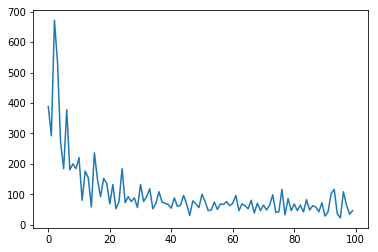

In [6]:
#pdb.set_trace()
maze = MDP_for_SimpleMaze(Map, Start_Position)
result = SARSA(maze, 100, greedy_policy)
x = np.arange(0, 100)
y = np.asarray(result)
plt.plot(x, y)